# 波士顿房价预测任务 

## 线性回归模型

假设房价和各影响因素之间能够用线性关系来描述：

$$y = {\sum_{j=1}^Mx_j w_j} + b$$

模型的求解即是通过数据拟合出每个$w_j$和$b$。其中，$w_j$和$b$分别表示该线性模型的权重和偏置。一维情况下，$w_j$ 和 $b$ 是直线的斜率和截距。

线性回归模型使用均方误差作为损失函数（Loss），用以衡量预测房价和真实房价的差异，公式如下：

$$MSE = \frac{1}{n} \sum_{i=1}^n(\hat{Y_i} - {Y_i})^{2}$$

# python+numpy

### 数据处理

数据处理包含五个部分：数据导入、数据形状变换、数据集划分、数据归一化处理和封装`load data`函数。数据预处理后，才能被模型调用。
#### 读入数据
通过如下代码读入数据，了解下波士顿房价的数据集结构，数据存放在本地目录下housing.data文件中。
#### 数据形状变换
由于读入的原始数据是1维的，所有数据都连在一起。因此需要我们将数据的形状进行变换，形成一个2维的矩阵，每行为一个数据样本（14个值），每个数据样本包含13个$X$（影响房价的特征）和一个$Y$（该类型房屋的均价）。
#### 数据集划分
将数据集划分成训练集和测试集，其中训练集用于确定模型的参数，测试集用于评判模型的效果。
在本案例中，我们将80%的数据用作训练集，20%用作测试集，实现代码如下。通过打印训练集的形状，可以发现共有404个样本，每个样本含有13个特征和1个预测值。
#### 数据归一化处理
对每个特征进行归一化处理，使得每个特征的取值缩放到0~1之间。这样做有两个好处：一是模型训练更高效；二是特征前的权重大小可以代表该变量对预测结果的贡献度（因为每个特征值本身的范围相同）。

In [80]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 数据形状变换
    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [81]:
# 获取数据
training_data, test_data = load_data()
x = training_data[:, :-1]
y = training_data[:, -1:]

## 模型设计

模型设计是深度学习模型关键要素之一，也称为网络结构设计，相当于模型的假设空间，即实现模型“前向计算”（从输入到输出）的过程。

如果将输入特征和输出预测值均以向量表示，输入特征$x$有13个分量，$y$有1个分量，那么参数权重的形状（shape）是$13\times1$。

## 训练过程

上述计算过程描述了如何构建神经网络，通过神经网络完成预测值和损失函数的计算。接下来介绍如何求解参数$w$和$b$的数值，这个过程也称为模型训练过程。训练过程是深度学习模型的关键要素之一，其目标是让定义的损失函数$Loss$尽可能的小，也就是说找到一个参数解$w$和$b$，使得损失函数取得极小值。

### 梯度下降法

在现实中存在大量的函数正向求解容易，但反向求解较难，被称为单向函数，这种函数在密码学中有大量的应用。密码锁的特点是可以迅速判断一个密钥是否是正确的(已知$x$，求$y$很容易)，但是即使获取到密码锁系统，无法破解出正确的密钥是什么（已知$y$，求$x$很难）。

这种情况特别类似于一位想从山峰走到坡谷的盲人，他看不见坡谷在哪（无法逆向求解出$Loss$导数为0时的参数值），但可以伸脚探索身边的坡度（当前点的导数值，也称为梯度）。那么，求解Loss函数最小值可以这样实现：从当前的参数取值，一步步的按照下坡的方向下降，直到走到最低点。这就是“梯度下降法”。

Epoch   0 / iter   0, loss = 6.3256
Epoch   0 / iter   1, loss = 5.8511
Epoch   0 / iter   2, loss = 2.0103
Epoch   0 / iter   3, loss = 0.9236
Epoch   0 / iter   4, loss = 0.3894
Epoch   1 / iter   0, loss = 0.2812
Epoch   1 / iter   1, loss = 0.1347
Epoch   1 / iter   2, loss = 0.0898
Epoch   1 / iter   3, loss = 0.0485
Epoch   1 / iter   4, loss = 0.0057
Epoch   2 / iter   0, loss = 0.0407
Epoch   2 / iter   1, loss = 0.0237
Epoch   2 / iter   2, loss = 0.0176
Epoch   2 / iter   3, loss = 0.0231
Epoch   2 / iter   4, loss = 0.0047
Epoch   3 / iter   0, loss = 0.0253
Epoch   3 / iter   1, loss = 0.0200
Epoch   3 / iter   2, loss = 0.0177
Epoch   3 / iter   3, loss = 0.0210
Epoch   3 / iter   4, loss = 0.0478
Epoch   4 / iter   0, loss = 0.0237
Epoch   4 / iter   1, loss = 0.0232
Epoch   4 / iter   2, loss = 0.0172
Epoch   4 / iter   3, loss = 0.0205
Epoch   4 / iter   4, loss = 0.0076
Epoch   5 / iter   0, loss = 0.0220
Epoch   5 / iter   1, loss = 0.0174
Epoch   5 / iter   2, loss =

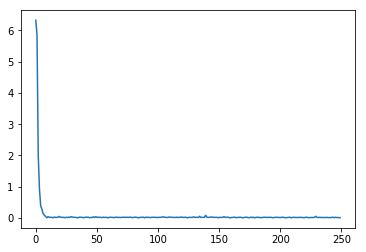

In [161]:
import numpy as np

def sigmoid(x):
    # sigmoid激活函数
    return 1/(1+np.exp(-x))

def dsigmoid(x):
    # sigmoid激活函数的导数
    return x*(1-x)

class Network(object):
    def __init__(self, num_of_weights,hidden_sum):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w_1 = np.random.randn(num_of_weights, hidden_sum)  # 第一个全连接层的网络参数
        self.b_1 = np.zeros(hidden_sum)
        self.w_2 = np.random.randn(hidden_sum,1) # 第二个全连接层的网络参数
        self.b_2 = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w_1) + self.b_1  # 全连接层
        z = sigmoid(z)  # sigmoid激活层
        z = np.dot(z, self.w_2) + self.b_2  # 全连接层
        return z
    
    # 损失函数 均方误差
    def loss(self, z, y):
        error = z - y
        cost = error * error
        num_samples = error.shape[0]
        cost = np.sum(cost) / num_samples
        return 0.5*cost
    
    # 计算梯度
    def gradient(self, x, y):
        # 梯度计算
        o_1 = sigmoid(np.dot(x, self.w_1) + self.b_1)  # 第一个全连接层的输出
        z = self.forward(x)  # 第一个全连接层的输出

        gradient_w_1 = x.T.dot((z-y).dot(self.w_2.T) * dsigmoid(o_1))   # 第一个全连接层参数的梯度
        gradient_b_1 = np.mean((z-y).dot(self.w_2.T) * dsigmoid(o_1), axis=0) 

        gradient_w_2 = np.mean((z-y)*o_1,axis=0)  # 第二个全连接层参数的梯度
        gradient_w_2 = gradient_w_2[:,np.newaxis]
        gradient_b_2 = np.mean((z-y))
        return gradient_w_1, gradient_b_1, gradient_w_2, gradient_b_2
    
    def update(self, gradient_w_1, gradient_w_2, gradient_b_1, gradient_b_2,eta):
        self.w_1 = self.w_1 - eta * gradient_w_1
        self.b_1 = self.b_1 - eta * gradient_b_1
        self.w_2 = self.w_2 - eta * gradient_w_2
        self.b_2 = self.b_2 - eta * gradient_b_2
            
    # 随机梯度下降法（ Stochastic Gradient Descent）            
    def train(self, training_data, num_epochs, batch_size=100, eta=0.1):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w_1, gradient_b_1, gradient_w_2, gradient_b_2 = self.gradient(x, y)  # 参数梯度
                self.update(gradient_w_1, gradient_w_2, gradient_b_1, gradient_b_2, eta)  # 更新参数
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

    def test(self,test_data):
        x = test_data[:, :-1]   # 特征
        y = test_data[:, -1:]   # 标签
        a = self.forward(x)      # 网络输出
        loss = self.loss(a, y)   # 网络损失
        print('The testing loss = {:.4f}'.format(loss))



# 获取数据
train_data, test_data = load_data()

# 创建网络
net = Network(13,8)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.1)
net.test(test_data)  # 测试集的效果

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

# 使用飞桨构建波士顿房价预测模型

In [128]:
#在数据处理之前，需要先加载飞桨框架的相关类库。
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import numpy as np
import os
import random
import matplotlib.pyplot as plt

代码中参数含义如下：

* paddle：飞桨的主库，paddle 根目录下保留了常用API的别名，当前包括：paddle.tensor、paddle.framework目录下的所有API。

* paddle.nn：组网相关的API，例如 Linear 、卷积 Conv2D 、 循环神经网络 LSTM 、损失函数 CrossEntropyLoss 、 激活函数 ReLU 等。

* Linear：神经网络的全连接层函数，即包含所有输入权重相加的基本神经元结构。在房价预测任务中，使用只有一层的神经网络（全连接层）来实现线性回归模型。

* paddle.nn.functional：与paddle.nn一样，包含组网相关的API，例如Linear、激活函数ReLu等。两者下的同名模块功能相同，运行性能也基本一致。 但是，paddle.nn下的模块均是类，每个类下可以自带模块参数；paddle.nn.functional下的模块均是函数，需要手动传入模块计算需要的参数。在实际使用中，卷积、全连接层等层本身具有可学习的参数，建议使用paddle.nn模块，而激活函数、池化等操作没有可学习参数，可以考虑直接使用paddle.nn.functional下的函数代替。
<br></br>

数据处理



In [141]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 数据形状变换
    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data


### 模型设计
实现过程分如下两步：

1. **定义init函数**：在类的初始化函数中声明每一层网络的实现函数。在房价预测模型中，只需要定义一层全连接层。
1. **定义forward函数**：构建神经网络结构，实现前向计算过程，并返回预测结果，在本任务中返回的是房价预测结果。

In [142]:
class Regressor(paddle.nn.Layer):

    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义2层全连接层，第一层输入维度是13，输出维度是8，第二层输入为8，输出为1
        self.fc1 = Linear(in_features=13, out_features=8)
        self.fc2 = Linear(in_features=8, out_features=1)
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc1(inputs)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

In [143]:
# 声明定义好的线性回归模型
model = Regressor()
# 开启模型训练模式
model.train()
# 加载数据
training_data, test_data = load_data()
# 定义优化算法，使用随机梯度下降SGD
# 学习率设置为0.1
opt = paddle.optimizer.SGD(learning_rate=0.1, parameters=model.parameters())

训练模型

epoch: 0/ iter: 0, loss is: 0.013656497932970524
epoch: 0/ iter: 1, loss is: 0.009776579216122627
epoch: 0/ iter: 2, loss is: 0.01251570601016283
epoch: 0/ iter: 3, loss is: 0.01221397239714861
epoch: 0/ iter: 4, loss is: 0.14746616780757904
epoch: 1/ iter: 0, loss is: 0.029910515993833542
epoch: 1/ iter: 1, loss is: 0.020103542134165764
epoch: 1/ iter: 2, loss is: 0.009747287258505821
epoch: 1/ iter: 3, loss is: 0.014623909257352352
epoch: 1/ iter: 4, loss is: 0.002632832620292902
epoch: 2/ iter: 0, loss is: 0.014526795595884323
epoch: 2/ iter: 1, loss is: 0.007702362723648548
epoch: 2/ iter: 2, loss is: 0.014702584594488144
epoch: 2/ iter: 3, loss is: 0.016314875334501266
epoch: 2/ iter: 4, loss is: 0.02050354704260826
epoch: 3/ iter: 0, loss is: 0.021532204002141953
epoch: 3/ iter: 1, loss is: 0.01183726079761982
epoch: 3/ iter: 2, loss is: 0.008866339921951294
epoch: 3/ iter: 3, loss is: 0.01304091140627861
epoch: 3/ iter: 4, loss is: 0.006978966295719147
epoch: 4/ iter: 0, loss is

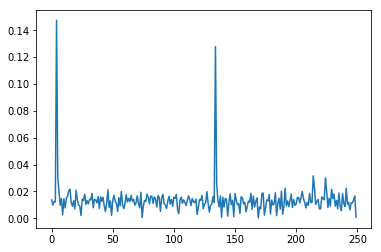

In [156]:
EPOCH_NUM = 50   # 设置外层循环次数
BATCH_SIZE = 100  # 设置batch大小
def train(EPOCH_NUM,BATCH_SIZE):
    # 定义外层循环
    losses = []
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分，每个batch包含100条数据
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
            house_features = paddle.to_tensor(x)
            prices = paddle.to_tensor(y)

            # 前向计算
            predicts = model(house_features)

            # 计算损失
            loss = F.square_error_cost(predicts, label=prices)
            avg_loss = paddle.mean(loss)
            losses.append(np.squeeze(avg_loss.numpy()))
            print("epoch: {}/ iter: {}, loss is: {}".format(epoch_id, iter_id, np.squeeze(avg_loss.numpy())))

            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
    return losses


losses = train(EPOCH_NUM, BATCH_SIZE)

plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()


In [157]:
# 保存模型参数，文件名为LR_model.pdparams
paddle.save(model.state_dict(), 'LR_model.pdparams')
print("模型保存成功，模型参数保存在LR_model.pdparams中")

模型保存成功，模型参数保存在LR_model.pdparams中


### 测试集效果

In [160]:
    x = np.array(test_data[:, :-1]) # 获得当前批次训练数据
    y = np.array(test_data[:, -1:]) # 获得当前批次训练标签（真实房价）
    # 将numpy数据转为飞桨动态图tensor形式
    house_features = paddle.to_tensor(x)
    prices = paddle.to_tensor(y)

    # 前向计算
    predicts = model(house_features)

    # 计算损失
    loss = F.square_error_cost(predicts, label=prices)
    avg_loss = paddle.mean(loss)
    print("The test loss is: {}".format(np.squeeze(avg_loss.numpy())))

The test loss is: 0.012102206237614155


### 测试模型

下面我们选择一条数据样本，测试下模型的预测效果。测试过程和在应用场景中使用模型的过程一致，主要可分成如下三个步骤：

1. 配置模型预测的机器资源。本案例默认使用本机，因此无需写代码指定。
1. 将训练好的模型参数加载到模型实例中。由两个语句完成，第一句是从文件中读取模型参数；第二句是将参数内容加载到模型。加载完毕后，需要将模型的状态调整为``eval()``（校验）。上文中提到，训练状态的模型需要同时支持前向计算和反向传导梯度，模型的实现较为臃肿，而校验和预测状态的模型只需要支持前向计算，模型的实现更加简单，性能更好。
1. 将待预测的样本特征输入到模型中，打印输出的预测结果。

通过``load_one_example``函数实现从数据集中抽一条样本作为测试样本，具体实现代码如下所示。

In [151]:
def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    idx = np.random.randint(0, test_data.shape[0])
    idx = -10
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label


In [152]:
# 参数为保存模型参数的文件地址
model_dict = paddle.load('LR_model.pdparams')
model.load_dict(model_dict)
model.eval()

# 参数为数据集的文件地址
one_data, label = load_one_example()
# 将数据转为动态图的variable格式 
one_data = paddle.to_tensor(one_data)
predict = model(one_data)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict.numpy(), label))

Inference result is [[33.81375]], the corresponding label is 38.87574005126953


对比两次结果可知，结果相似